## Issuance of a PRC as QR code

In [85]:
# Load the private key from the PEM file
with open('private_key_ec.pem', 'rb') as f:
    private_key_pem = f.read()

In [86]:
# Compute fingerprint of private key
from helper import get_ec_private_key_fingerprint
fingerprint = get_ec_private_key_fingerprint(private_key_pem)
print("Hex-encoded fingerprint:", fingerprint)

Hex-encoded fingerprint: 3e47b334052d2575f1943c8af41026580810f88c30a236db0ef19bdd8a5d92a2


### EHIC data sample

In [87]:
sample_ehic_data = {
    "ic": "BE",
    "hn": {
        "fn": "Clément-Lafarge",
        "gn": "Jean-Pierre, Frédéric",
    },
    "dob": "29-02-2000",
    "hi": "0001019999",
    "ii": "0216X",
    "in": "LAMUTUALITENEUTRE",
    "ci": "021XXXXXXX2023035407",
    "sd": "28-02-2023",
    "ed": "29-02-2024",
    "id": "31-01-2024"
}
print("Approx. byte size:", len(str(sample_ehic_data)))

Approx. byte size: 249


### Create payload of verifiable credential
The credentialSubject is the actual EHIC data sample

In [88]:
verifiable_credential = {
    "@context": [
        "https://www.w3.org/2018/credentials/v1",
        "https://w3id.org/vc/status-list/2021/v1"
    ],
    "type": [
        "VerifiableCredential",
        "EHICCredential"
    ],
    "credentialSubject": sample_ehic_data,
    "credentialSchema": {
        "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
        "type": "FullJsonSchemaValidator2021"
    }
}
print("Approx. byte size:", len(str(verifiable_credential)))

Approx. byte size: 622


### Build JSON web token

In [89]:
import jwt
import datetime
import json

# Define the content of the JWT
payload = {
    "iat": int(datetime.datetime.now().timestamp()),  # Issued at
    "nbf": int(datetime.datetime.now().timestamp()),  # Not before
    "exp": int((datetime.datetime.now() + datetime.timedelta(days=365)).timestamp()), # Expiration date
    "vc": verifiable_credential,
    "iss": f"ESSI:BE:0100:{fingerprint}", # Issuer
}

print(json.dumps(payload, indent=4))
print("Approx. byte size:", len(str(payload)))

{
    "iat": 1741195553,
    "nbf": 1741195553,
    "exp": 1772731553,
    "vc": {
        "@context": [
            "https://www.w3.org/2018/credentials/v1",
            "https://w3id.org/vc/status-list/2021/v1"
        ],
        "type": [
            "VerifiableCredential",
            "EHICCredential"
        ],
        "credentialSubject": {
            "ic": "BE",
            "hn": {
                "fn": "Cl\u00e9ment-Lafarge",
                "gn": "Jean-Pierre, Fr\u00e9d\u00e9ric"
            },
            "dob": "29-02-2000",
            "hi": "0001019999",
            "ii": "0216X",
            "in": "LAMUTUALITENEUTRE",
            "ci": "021XXXXXXX2023035407",
            "sd": "28-02-2023",
            "ed": "29-02-2024",
            "id": "31-01-2024"
        },
        "credentialSchema": {
            "id": "https://api-pilot.ebsi.eu/trusted-schemas-registry/v3/schemas/0xfa899fd2bc2a5a66ad51f9881813401ebe02f7dd40b0926c3e49c9514a77cb6a",
            "type": "FullJsonSc

### Sign JWT

In [90]:
encoded_jws = jwt.encode(payload, private_key_pem, algorithm='ES256')
print("Encoded JWS (JWT):", encoded_jws)
print("Approx. byte size:", len(encoded_jws))

Encoded JWS (JWT): eyJhbGciOiJFUzI1NiIsInR5cCI6IkpXVCJ9.eyJpYXQiOjE3NDExOTU1NTMsIm5iZiI6MTc0MTE5NTU1MywiZXhwIjoxNzcyNzMxNTUzLCJ2YyI6eyJAY29udGV4dCI6WyJodHRwczovL3d3dy53My5vcmcvMjAxOC9jcmVkZW50aWFscy92MSIsImh0dHBzOi8vdzNpZC5vcmcvdmMvc3RhdHVzLWxpc3QvMjAyMS92MSJdLCJ0eXBlIjpbIlZlcmlmaWFibGVDcmVkZW50aWFsIiwiRUhJQ0NyZWRlbnRpYWwiXSwiY3JlZGVudGlhbFN1YmplY3QiOnsiaWMiOiJCRSIsImhuIjp7ImZuIjoiQ2xcdTAwZTltZW50LUxhZmFyZ2UiLCJnbiI6IkplYW4tUGllcnJlLCBGclx1MDBlOWRcdTAwZTlyaWMifSwiZG9iIjoiMjktMDItMjAwMCIsImhpIjoiMDAwMTAxOTk5OSIsImlpIjoiMDIxNlgiLCJpbiI6IkxBTVVUVUFMSVRFTkVVVFJFIiwiY2kiOiIwMjFYWFhYWFhYMjAyMzAzNTQwNyIsInNkIjoiMjgtMDItMjAyMyIsImVkIjoiMjktMDItMjAyNCIsImlkIjoiMzEtMDEtMjAyNCJ9LCJjcmVkZW50aWFsU2NoZW1hIjp7ImlkIjoiaHR0cHM6Ly9hcGktcGlsb3QuZWJzaS5ldS90cnVzdGVkLXNjaGVtYXMtcmVnaXN0cnkvdjMvc2NoZW1hcy8weGZhODk5ZmQyYmMyYTVhNjZhZDUxZjk4ODE4MTM0MDFlYmUwMmY3ZGQ0MGIwOTI2YzNlNDljOTUxNGE3N2NiNmEiLCJ0eXBlIjoiRnVsbEpzb25TY2hlbWFWYWxpZGF0b3IyMDIxIn19LCJpc3MiOiJFU1NJOkJFOjAxMDA6M2U0N2IzMzQwNTJkMjU3NWYxOTQzYzhhZjQx

### Generate QR code

Compress encoded JWS using ZLib

In [91]:
import zlib
import base64

# Compress the JWS using zlib
compressed_jws = zlib.compress(encoded_jws.encode('utf-8'))

compressed_jws_b64 = base64.b64encode(compressed_jws).decode('utf-8')
print("Compressed JWS (base64):", compressed_jws_b64)
print("Approx. byte size:", len(compressed_jws))

Compressed JWS (base64): eJxdU12TqjgQ/UV3C0Gc4VFFMFwTFgwfycuWhBkJBOWWjpD8+m10bu3Hg0V5oPucPn36Q0dNFQoZyyjIDFoQiW7okrpii1aoG8p8G3l/fOhoYGUi43bnEH83xTRbEIpvqHcll2iFqbAw3bkEcKxHyctmRO11IkZoYvAEuDlsI5tptIJea2Z7X3WYL2sgKXR0rffpKMz1cXBqp9aug7X7EL144HY9xVuvFX3e8cK1TkVwE9qz8RFE9o1V7zcmlu+P2pCBb181dY8fwkmbep+bQzENwknmPhof57qoBh3WR7lRqB0qpLgSveqhr6zC3P83D5KjTLMmSiyieZGq6pIOrBhleRwlcyLFwxxmUE0VkAXrB8Uc8Odyk6cCz2Zu05fGL+B5Qz2H51Um9iRquh45VfeZ55BNDe8Dze1Mgq5LJZ+mK1Ys71molLhE6rDdhEJNC+xvVFykv+v1zPMJWnjoybk3brs79tEdZh3x9sk9PHEf/lPwkXZu/NSkvnE0EXWeeYcX77SheZ7lWYCPeRrQLs/zIApmH5jdwUxoxG3AiqB5/p6emrUhNBmJnkNDupeO828dGs84ePo/fZo89akXbnaA777xyAM9/9l3ZpMrLxbNy8dXzWmfWmKPVwftNSLs7iJUt8pJvngRmdPRVfXRs8QlN5Cx7lCS9hTmd1biO/S9nEoC77pH3UJOvnsL/T5+hLyJ/c7lfaJZjzWjeUNa3nA/m3jbLWN/t8QUW9gPFOuzEffM4WFi4RCNMUU2M0QRX7VwGxMJ4U5sIkm/k//k7SrTS36rdoOpbJcyu1FVERQMMsrDwKocpOedoMti9gByi19HuSBR3EVBDLcAu1xhO7OIjQw24DuNOtxmDikY7DcxzDQNbxP4DtmEnkfQPPL2vGQGj4wiQ/pU4jDvMVWQm2QJM3YxjRos4chPLv/1q58WflqQw1/lu3n/bLU6/5TLTXmul7zehVNSebc

Encode the compressed data using Base45

In [92]:
import base45

base45_encoded = base45.b45encode(compressed_jws)
print("Base45 encoded JWS:", base45_encoded)
print("Approx. byte size:", len(base45_encoded))

Base45 encoded JWS: b'6BF-ZBF$BGNLT628Z81J1L$JFCA556QI2/N1:MPC1JJ73%R0M1J EITTVGWEV2UZQG-GFH VM+7WSVS09VT2XB3075CP1342.0EWOIRKC:.A4N31VF8GFQZFZ8DFZC0YSM9TW3G*-O2NBOMHHDL%X4R9DFKL:76OHN:AEH395WP5W8G EO+8%MC%Q0UB7PM4FGDTLG:PD%QF:%EY:5/24MWEU:LILT:+PFFEXLDD6RCTGCXV*.N.GSI 7QQBBW2D8SUROC+9Q7E7TRILUEW81*H*AUN*4$CUHSRFGGS1CZ%EU04XD9QMFCSJ296CPO$4TRD3CDT*ALXY3139OEA-U33$KRG2ZTTH9MOSO+BWQ/1:SK7TM/G9DOKUIIKTTL%1Z33:DF2X4 H4/TO2.CNX9E9I2WTF-OLKU LE45L*9QL0EJ8JG26%EF1Z71BTT-47R4 NN7B7PDVFCTFX9W9UM1QBU9O1M1Y4E0LA+ASBU1ELCDN5UT80S8H8$M1F3E1WB BOE3VRWUUJBDJTUIN.:D5Q7SJQ-+CMQU$JP%S7024NRANHIH1EV*QI3O9Q65*EGGF713Q$M*GFX:SGBG.DFEEQ0DQC24/+CSEJTJO0BDG*DSNH0JFG2K5PJ+84CA3F0KDP887J*YUPU3%8QADF818JMJO2VD/26:E*DULPUJI0MFWB4FARI*.5X0Q19PP/PO6KVKC40BK:TUI4W4U.VAZPPP3O5A20ZQ0*A/MQ%ZO417AMMG8A-4V46TC:A3Q7U/N1G9ZDU$399H8S3O9N1N+75ZG0KH07QW*FMEB6Z6%EF.LBP8EKTJ*VR1QCJAN P26ER0T2VSMVEV7MSNMC742DA6F%6AR8L4CY7EDI2XLS7UDOE9.VIF.SSI5LO9JUL0TGYWDRI6VCA772HO1MSP2GO.R3SCTXEK:MCO20*RH139%344%R2A836N*UN6DCFVMI$H8.6ZN7%J7Q+C

Generate QR code

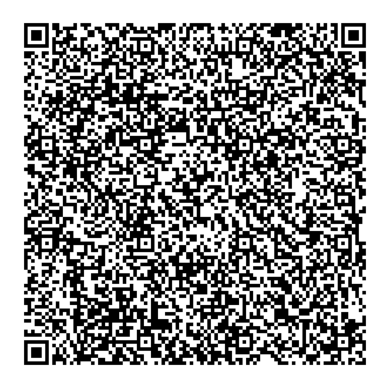

In [93]:
import qrcode
import matplotlib.pyplot as plt

# Create a QR code instance
qr = qrcode.QRCode(
    version=1,  # Controls the size of the QR Code
    error_correction=qrcode.constants.ERROR_CORRECT_L,
    box_size=10,
    border=4,
)

qr.add_data(base45_encoded)
qr.make(fit=True)

# Create an image from the QR code instance
img = qr.make_image(fill='black', back_color='white')
img.save("qrcode.png")


# Display the image in the notebook
plt.imshow(img, cmap='gray')
plt.axis('off')  # Hide the axis
plt.show()